# Klasyfikacja obrazu za pomocą Sieci Konwolucyjnych, część II

![alt text](https://raw.githubusercontent.com/wojtekcz/camera_retrained/develop/images/iphone6_spacegrey_portrait.png)

## Załadowanie bibliotek

In [0]:
# Put these at the top of every notebook, to get automatic reloading
%reload_ext autoreload
%autoreload 2

#matplotlib setup
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import matplotlib.style
import matplotlib as mpl
mpl.style.use('default')
mpl.style.use('seaborn-ticks')
# %config InlineBackend.figure_format = 'retina'

import warnings
warnings.filterwarnings('ignore')
from pathlib import Path
import shutil as sh

# This file contains all the main external libs we'll use
from fastai.imports import *

from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots_wcz import *

# Proste kroki do wyszkolenia klasyfikatora obrazu światowej klasy

* Wykorzystać transfer learning, użyć (fragmenty) wytrenowanych sieci
* Trenować interaktywnie

## Kroki

1. Włącz augmentację danych oraz cache aktywacji (precompute=True)
1. Użyj `lr_find()`, aby znaleźć najwyższy wskaźnik uczenia się, w którym strata (loss) jeszcze się poprawia
1. Wytrenuj ostatnią warstwę z prekomputowanych aktywacji przez 1-2 epoki
1. Wytrenuj ostatnią warstwę z augmentacją danych (tj. precompute = False) przez 2-3 epoki z cycle_len = 1
1. Odblokuj wszystkie warstwy
1. Ustaw dla wcześniejszych warstw 3x-10x mniejszy krok uczenia się niż dla kolejnych wyższych warstw
1. Ponownie użyj `lr_find()`
1. Trenuj całą sieć z cycle_mult = 2 aż do dopasowania

# Fine-tuning

`ConvLearner.pretrained` buduje *ucznia* który stanowi wcześniej wytrenowany model. Ostatnia warstwa modelu musi zostać zastąpiona warstwą odpowiednich wymiarów. Ten model został wyszkolony dla 1000 klas, a ostateczna warstwa przewiduje wektor o prawdopodobieństwie 1000. Model dla starych polskich samochodów musi wyprowadzić wektor dwuwymiarowy. Poniższy schemat pokazuje w przykładzie, w jaki sposób zostało to zrobione w jednym z najwcześniej odnoszących sukces CNN. Warstwa "FC8" zostanie tutaj zastąpiona nową warstwą z 10 wyjściami.

<img src="https://image.slidesharecdn.com/practicaldeeplearning-160329181459/95/practical-deep-learning-16-638.jpg" width="500">
[original image](https://image.slidesharecdn.com/practicaldeeplearning-160329181459/95/practical-deep-learning-16-638.jpg)

*Parametry* są wyuczane poprzez dopasowanie modelu do danych. * Hyparameters * to kolejny rodzaj parametru, którego nie można bezpośrednio nauczyć się ze zwykłego procesu treningowego. Parametry te wyrażają właściwości "wyższego poziomu" modelu, takie jak jego złożoność lub szybkość uczenia. Dwa przykłady hiperparametrów to * wskaźnik uczenia się * i * liczba epok *.

Podczas iteracyjnego szkolenia sieci neuronowej, * partia (batch) * lub * mini-partia (mini-batch) * jest podzbiorem próbek szkoleniowych używanych w jednej iteracji Stochastycznego Schodzenia Gradientowego (SGD). Epoka * * to pojedyncze przejście przez cały zestaw treningowy, który składa się z wielu iteracji SGD.

Możemy teraz * dopasować (fit) * model; to znaczy, użyj * gradientowego spadku (gradient descent) *, aby znaleźć najlepsze parametry dla w pełni połączonej warstwy, którą dodaliśmy, która może oddzielać maluchowe obrazy od polonezowych obrazów. Musimy zdać dwa hipertermery: * wskaźnik uczenia się (learning rate)* (ogólnie 1e-2 lub 1e-3 jest dobrym punktem wyjścia, przyjrzymy się temu dalej) i * liczbie epok * (możesz podać wyższy poziom liczbę i po prostu przestań trenować, gdy zauważysz, że już się nie poprawia, a następnie uruchom ponownie z liczbą odnalezionych epok).

## Mój dataset: 'Old Polish Cars v5'

In [0]:
PATH = "data/old_polish_cars/old_polish_cars_v5_photos-split/"

In [3]:
ls -lah /content/data/old_polish_cars

total 5.5G
drwxr-xr-x  5 root      root      4.0K Apr 29 08:42 ./
drwxr-xr-x  3 root      root      4.0K Apr 29 06:14 ../
drwxr-xr-x  7 root      root      4.0K Apr 29 08:46 old_polish_cars_two_classes_v2a-split/
-rw-r--r--  1 root      root      707M Apr 29 08:42 old_polish_cars_two_classes_v2a-split.zip
drwxr-xr-x 12 349452163 349400513 4.0K Apr 28 19:09 old_polish_cars_v4_photos/
-rw-r--r--  1 root      root      2.4G Apr 29 06:15 old_polish_cars_v4_photos-20180428.tgz
drwxr-xr-x  6 349452163 349400513 4.0K Apr 29 08:19 old_polish_cars_v5_photos-split/
-rw-r--r--  1 root      root      2.4G Apr 29 06:14 old_polish_cars_v5_photos-split-2017-11-15.tgz


## Sprawdzenie, czy dataset jest dostępny

In [4]:
!ls {PATH}

models	tmp  train  valid


In [5]:
!ls {PATH}valid

Autobus Jelcz MZK     Fiat 125p		FSC Zuk      FSO Warszawa  Syrena 105
Autobus Jelcz Ogorek  Fiat 126p Maluch	FSO Polonez  Gazik	   ZSD Nysa


In [6]:
files = !ls {PATH}valid/"FSO Warszawa" | head
files

['15_1487453323.84.jpg',
 '21_1487453327.45.jpg',
 '32_1487453346.6_ddd.jpg',
 '33_1487453347.16_ddd_ddd.jpg',
 '44_1487453358.99_ddd.jpg',
 '46_1487453360.68_ddd.jpg',
 '48_1487453364.29_ddd_ddd.jpg',
 '56_1487453384.48_ddd_ddd.jpg',
 '63_1487453393.01_ddd_ddd.jpg',
 '67_1487453399.4.jpg']

In [7]:
files[9]

'67_1487453399.4.jpg'

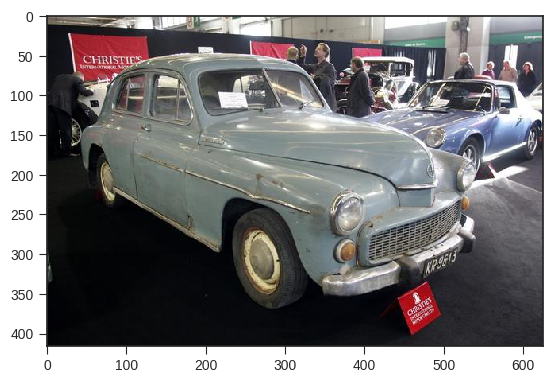

In [8]:
img = plt.imread(f'{PATH}valid/FSO Warszawa/{files[9]}')
plt.imshow(img);

# Trening(i) modelu

## 1. Włącz augmentację danych i cache aktywacji

In [0]:
sz=224  # sz=128
arch=resnet34

tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)

data = ImageClassifierData.from_paths(PATH, tfms=tfms)
learn = ConvLearner.pretrained(arch, data, precompute=True)

## 2. Znajdź krok uczenia się

In [10]:
lrf = learn.lr_find()

Widget Javascript not detected.  It may not be installed or enabled properly.


 89%|████████▉ | 123/138 [00:04<00:00, 26.76it/s, loss=9.1] 


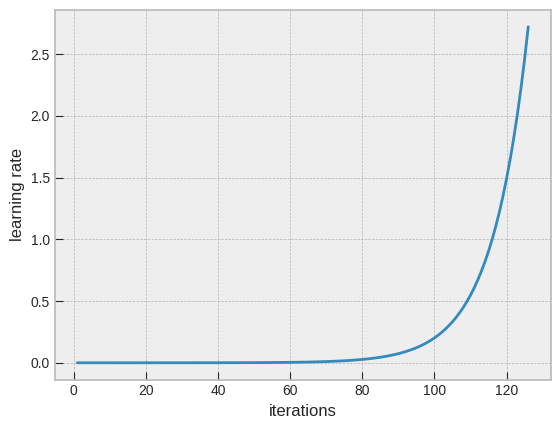

In [11]:
mpl.style.use('bmh')
# %config InlineBackend.figure_format = 'retina'
learn.sched.plot_lr()

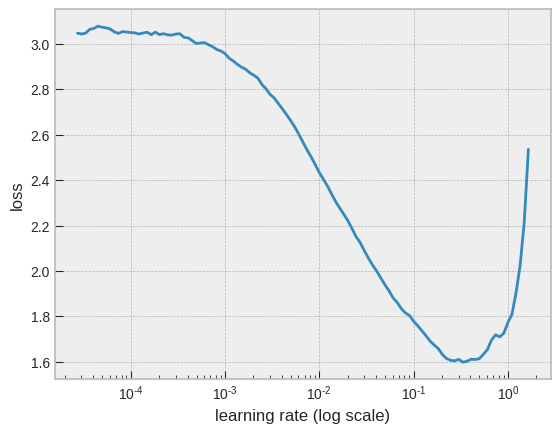

In [12]:
learn.sched.plot()

wybrany lr=0.08

In [0]:
0.8*10**-1

## 3. Wstępny trening
Wytrenuj ostatnią warstwę z prekomputowanych aktywacji przez 1-2 epoki

Domyślnie, gdy tworzymy obiekt learn, ustawia on wszystkie warstwy oprócz ostatniej na * zamrożone *. Oznacza to, że  aktualizuje wagi tylko w ostatniej warstwie, kiedy wywołujemy `fit`.

In [13]:
learn.fit(0.08, 3)  # fixed learning rate

Widget Javascript not detected.  It may not be installed or enabled properly.


epoch      trn_loss   val_loss   accuracy   
    0      0.700516   0.39929    0.858163  
    1      0.470866   0.335777   0.889796  
    2      0.383733   0.267338   0.912245  



[array([0.26734]), 0.9122448977158994]

In [0]:
learn.save('224_initial')

In [0]:
learn.load('224_initial')

## 4. Trenuj z augmentacją danych
Wytrenuj ostatnią warstwę z augmentacją danych (tj. precompute = False) przez 2-3 epoki z cycle_len = 1

In [16]:
learn.precompute=False
learn.fit(0.08, 3, cycle_len=1)

Widget Javascript not detected.  It may not be installed or enabled properly.


epoch      trn_loss   val_loss   accuracy   
    0      0.405454   0.221966   0.927551  
    1      0.375403   0.215011   0.92449   
  0%|          | 0/138 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

Co to jest parametr `cycle_len`? To, co tutaj zrobiliśmy, to metoda * stochastycznego gradientu prostego z restartem (SGDR) *, z wariantem * wyżarzania szybkości uczenia *, które stopniowo zmniejsza szybkość uczenia się w miarę postępu treningu. Jest to pomocne, ponieważ gdy zbliżamy się do optymalnych wag, chcemy podjąć mniejsze kroki.

Jednakże możemy znaleźć się w części przestrzeni wagi, która nie jest bardzo odporna - to znaczy niewielkie zmiany masy mogą spowodować duże zmiany w stratach. Chcemy zachęcić nasz model do znalezienia części przestrzeni wagi, które są zarówno dokładne, jak i stabilne. Dlatego od czasu do czasu zwiększamy szybkość uczenia się (jest to "restart" w "SGDR"), co zmusi model do przejścia do innej części przestrzeni wagi, jeśli obecny obszar jest "spiczasty". Oto obraz tego, jak to może wyglądać, jeśli zresetujemy współczynniki uczenia się 3 razy (w tym dokumencie nazywają to "cyklicznym harmonogramem LR"):

![SGDR](https://raw.githubusercontent.com/fastai/fastai/master/courses/dl1/images/sgdr.png)
(Z publikacji [Snapshot Ensembles](https://arxiv.org/abs/1704.00109)).

Liczba epok pomiędzy resetowaniem współczynnika uczenia się jest ustalana przez "cykl_liczba", a liczba razy, kiedy to się dzieje, jest określana jako * liczba cykli *, i jest tym, co faktycznie przekazujemy jako drugi parametr do "dopasowania" ( ) `. Oto jak wyglądały nasze rzeczywiste wskaźniki uczenia się:

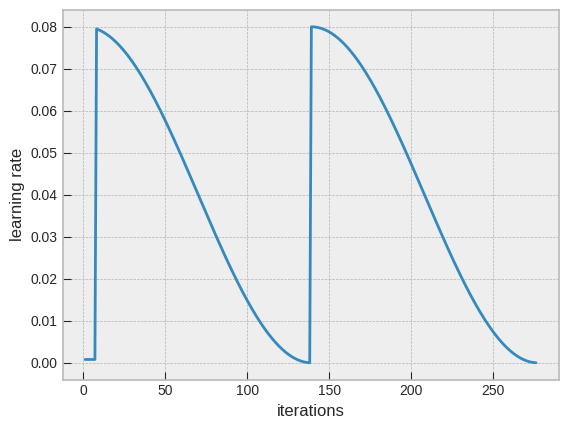

In [18]:
learn.sched.plot_lr()

Nasza strata w zakresie walidacji nie ulega znacznej poprawie, więc prawdopodobnie nie ma potrzeby dalszego szkolenia ostatniej warstwy na własną rękę.

Ponieważ w tym momencie mamy całkiem niezły model, możemy chcieć go zapisać, abyśmy mogli go załadować ponownie później bez szkolenia od zera.

In [0]:
learn.save('224_lastlayer')

In [0]:
learn.load('224_lastlayer')

## 5, 6 Dostrojenie pierwszych warstw i 'różnicowe hartowanie kroku uczenia się'
Odblokuj wszystkie warstwy<br/>
Ustaw dla wcześniejszych warstw 3x-10x mniejszy krok uczenia się niż dla kolejnych wyższych warstw

Teraz, gdy mamy już wytrenowaną dobrą warstwę końcową, możemy spróbować dopracować pozostałe warstwy. Aby powiedzieć uczniowi, że chcemy odblokować pozostałe warstwy, wystarczy użyć `unfreeze()`.

In [0]:
learn.unfreeze()

Zauważ, że pozostałe warstwy zostały * już * przeszkolone do rozpoznawania zdjęć imagenetowych (podczas gdy nasze końcowe warstwy zostały losowo zainicjowane), więc chcemy uważać, aby nie zniszczyć dokładnie wyregulowanych wag, które już tam są.

Ogólnie mówiąc, wcześniejsze warstwy (jak widzieliśmy) mają więcej funkcji ogólnego przeznaczenia. Dlatego oczekiwalibyśmy, że będą potrzebowali mniejszego dostrajania nowych zestawów danych. Z tego powodu użyjemy różnych poziomów nauki dla różnych warstw: pierwsze kilka warstw będzie na poziomie 1e-4, środkowe warstwy na 1e-3, a nasze warstwy FC opuścimy na 1e-2, tak jak poprzednio. Mówimy o tym jako o * zróżnicowanych wskaźnikach uczenia się *, chociaż nie ma standardowej nazwy dla tej technologii w literaturze, o której nam wiadomo.

In [0]:
lr = np.array([0.0008, 0.008, 0.08])
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

Kolejną sztuczką, której tutaj użyliśmy jest dodanie parametru `cycle_mult`. 

Cykle są mierzone w epokach, więc cycle_len = 1 samo w sobie oznaczałoby ciągłe zmniejszanie szybkości uczenia się w trakcie jednej epoki, a następnie przeskakiwanie z powrotem do góry. Parametr cycle_mult mówi, aby pomnożyć długość cyklu przez coś (w tym przypadku 2), jak tylko ukończysz jeden cykl.

In [0]:
learn.sched.plot_lr()

Zauważ, że to, co przedstawiono powyżej, to wskaźnik uczenia się * ostatnich warstw *. Współczynniki uczenia się wcześniejszych warstw są ustalane na tych samych wielokrotnościach ostatecznych poziomów warstw, zgodnie z pierwotnym żądaniem (tj. Pierwsze warstwy mają 100x mniejsze, a warstwy średnie 10x mniejsze szybkości uczenia się, ponieważ ustawiamy `lr = np.array ([ 1e-4,1e-3,1e-2]) ".

In [0]:
learn.save('224_all')

In [0]:
learn.load('224_all')

## 7. Ponownie użyj lr_find()

In [0]:
lrf = learn.lr_find()

In [0]:
learn.sched.plot()

## 8. Trenuj całą sieć z cycle_mult = 2 aż do dopasowania

In [0]:
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

In [0]:
learn.save('224_final')

In [0]:
learn.load('224_final')

# Predykcja na zestawie walidacyjnym

### Użycie TTA (Test Time Augmentation) przy predykcji

Jest jeszcze coś, co możemy zrobić z rozszerzeniem danych: użyj go w * czasie wnioskowania * (znanym również jako * czas testu *). Nic dziwnego, że jest to znane jako * augmentacia w czasie testu * lub po prostu * TTA *.

TTA po prostu tworzy prognozy nie tylko na obrazach w twoim zbiorze sprawdzania poprawności, ale także tworzy prognozy dla pewnej liczby losowo rozszerzonych wersji ich (domyślnie używa oryginalnego obrazu wraz z 4 losowo rozszerzonymi wersjami). Następnie pobiera średnie prognozy z tych obrazów i wykorzystuje je. Aby użyć TTA w zestawie sprawdzania poprawności, możemy skorzystać z metody "TTA ()" ucznia.

In [0]:
log_preds_tta, y_tta = learn.TTA()

In [0]:
probs_tta = np.mean(np.exp(log_preds_tta),0)
preds_tta = np.argmax(probs_tta, axis=1)  # from log probabilities to 0 or 1

In [0]:
probs_tta[0:3, :]

In [0]:
# preds_tta[:3]

In [0]:
accuracy_np(probs_tta, y_tta)

Zwykle widzę o 10-20% spadku błędu w tym zestawie danych podczas korzystania z TTA w tym momencie, co jest niesamowitym wynikiem dla tak szybkiej i prostej techniki!

### bez TTA

In [0]:
# this gives prediction for validation set. Predictions are in log scale
log_preds = learn.predict()
y = data.val_y

In [0]:
preds = np.argmax(log_preds, axis=1)  # from log probabilities to 0 or 1
probs = np.exp(log_preds);            # pr(car)

In [21]:
probs[0:3, :]

array([[0.99975, 0.00025, 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     ],
       [0.98287, 0.01713, 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     ],
       [0.99997, 0.00003, 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     ]],
      dtype=float32)

In [0]:
preds[:3]

In [0]:
print('preds: ', len(preds), preds[0:10], '\nprobs: ', len(probs), probs[0:10])

In [22]:
accuracy_np(probs, y)

0.9244897959183673

## Analiza wyników

### Tablica pomyłek

In [0]:
from sklearn.metrics import confusion_matrix

In [0]:
# y = y_tta
# preds = preds_tta

In [0]:
cm = confusion_matrix(y, preds)

[[98  0  0  0  0  0  0  0  0  0]
 [ 4 87  0  0  0  2  0  0  0  5]
 [ 0  0 97  1  0  0  0  0  0  0]
 [ 0  0  0 90  0  4  3  0  1  0]
 [ 0  0  1  1 92  0  2  0  2  0]
 [ 0  0  0  7  0 86  3  1  1  0]
 [ 0  0  0  4  1  4 88  1  0  0]
 [ 0  0  0  0  1  1  0 96  0  0]
 [ 0  0  0  0  8  7  2  0 81  0]
 [ 2  0  1  0  0  1  2  1  0 91]]


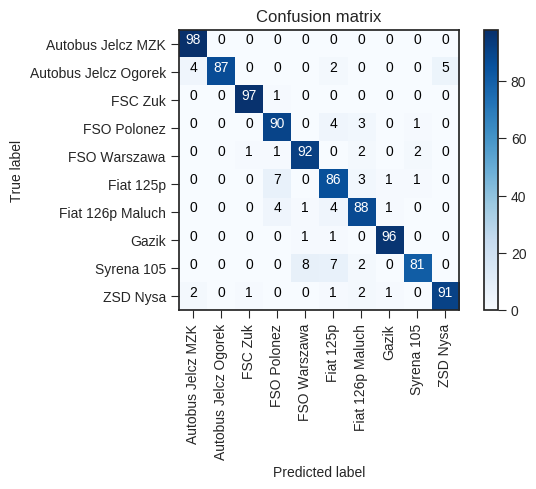

In [25]:
mpl.style.use('default')
mpl.style.use('seaborn-ticks')

# %config InlineBackend.figure_format = 'retina'

plot_confusion_matrix(cm, data.classes)

# Koniec